In [3]:
!pip install xgboost

  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)


In [4]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.4 MB/s eta 0:00:00


In [5]:
!pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
    --------------------------------------- 1.8/102.5 MB 8.4 MB/s eta 0:00:13
   - -------------------------------------- 4.5/102.5 MB 9.6 MB/s eta 0:00:11
   -- ------------------------------------- 5.5/102.5 MB 8.2 MB/s eta 0:00:12
   -- ------------------------------------- 6.8/102.5 MB 7.8 MB/s eta 0:00:13
   --- ------------------------------------ 7.9/102.5 MB 7.4 MB/s eta 0:00:13
   --- ------------------------------------ 8.4/102.5 MB 6.6 MB/s eta 0:00:15
   --- ------------------------------------ 8.9/102.5 MB 5.9 MB/s eta 0:00:16
   --- ------------------------------------ 9.2/102.5 MB 5.4 MB/s eta 0:00:18
   --- ------------------------------------ 9.4/102.5 MB 5.0 MB/s eta 0:00:19
   --- ------------------------------------ 9.7/102.5 MB 4.6 MB/s eta 0:00:20
   --- ------------------------------------ 10.0/102.5 MB 4.4 MB/s eta 0:00:22

In [6]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [7]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    

SEED = 42
set_seed(SEED)

In [9]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [10]:
print(f"Train shape: {train_df.shape}")
train_df.sample(3)

Train shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S


In [11]:
print(f"Test shape: {test_df.shape}")
test_df.sample(3)

Test shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
20,912,1,"Rothschild, Mr. Martin",male,55.00,1,0,PC 17603,59.40,NaN,C
338,1230,2,"Denbury, Mr. Herbert",male,25.00,0,0,C.A. 31029,31.50,NaN,S
250,1142,2,"West, Miss. Barbara J",female,0.92,1,2,C.A. 34651,27.75,NaN,S


In [12]:
full_df = pd.concat(
    [
        train_df.drop(["PassengerId", "Survived"], axis=1), 
        test_df.drop(["PassengerId"], axis=1),
    ]
)
y_train = train_df["Survived"].values

In [13]:
full_df.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [14]:
full_df = full_df.drop(["Age", "Cabin"], axis=1)

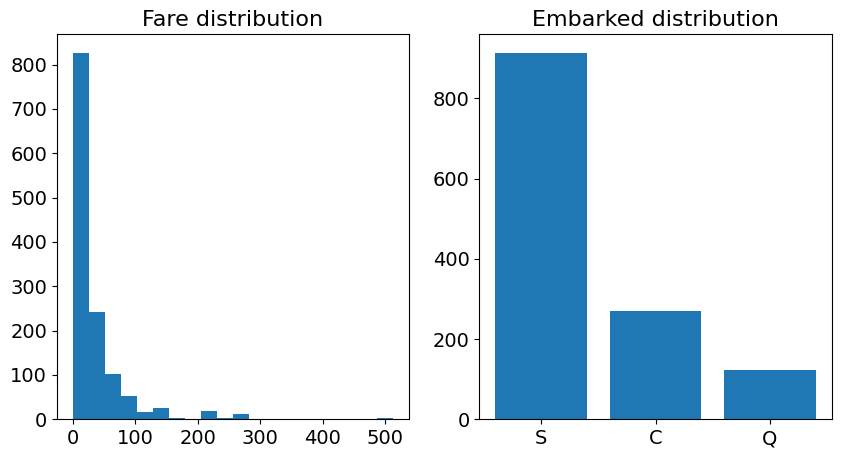

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(full_df["Fare"], bins=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Fare distribution", fontsize=16)

plt.subplot(1, 2, 2)
embarked_info = full_df["Embarked"].value_counts()
plt.bar(embarked_info.index, embarked_info.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Embarked distribution", fontsize=16);

In [16]:
full_df["Embarked"].fillna("S", inplace=True)
full_df["Fare"].fillna(full_df["Fare"].mean(), inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_11052\4104945223.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df["Embarked"].fillna("S", inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_11052\4104945223.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [17]:
full_df["Title"] = full_df["Name"].str.extract(" ([A-Za-z]+)\.")
full_df["Title"] = full_df["Title"].replace(["Ms", "Mlle"], "Miss")
full_df["Title"] = full_df["Title"].replace(["Mme", "Countess", "Lady", "Dona"], "Mrs")
full_df["Title"] = full_df["Title"].replace(["Dr", "Major", "Col", "Sir", "Rev", "Jonkheer", "Capt", "Don"], "Mr")
full_df = full_df.drop(["Name"], axis=1)

In [18]:
full_df["Sex"] = full_df["Sex"].map({"male": 1, "female": 0}).astype(int)    
full_df["Embarked"] = full_df["Embarked"].map({"S": 1, "C": 2, "Q": 3}).astype(int)    
full_df['Title'] = full_df['Title'].map({"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3}).astype(int) 

In [19]:
full_df["TicketNumber"] = full_df["Ticket"].str.split()
full_df["TicketNumber"] = full_df["TicketNumber"].str[-1]
full_df["TicketNumber"] = LabelEncoder().fit_transform(full_df["TicketNumber"])
full_df = full_df.drop(["Ticket"], axis=1)

In [20]:
full_df["FamilySize"] = full_df["SibSp"] + full_df["Parch"] + 1
full_df["IsAlone"] = full_df["FamilySize"].apply(lambda x: 1 if x == 1 else 0)

In [21]:
full_df.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,TicketNumber,FamilySize,IsAlone
0,3,1,1,0,7.2500,1,0,209,2,0
1,1,0,1,0,71.2833,2,2,166,2,0
2,3,0,0,0,7.9250,1,1,466,1,1
3,1,0,1,0,53.1000,1,2,67,2,0
4,3,1,0,0,8.0500,1,0,832,1,1


In [22]:
X_train = full_df[:y_train.shape[0]]
X_test = full_df[y_train.shape[0]:]

print(f"Train X shape: {X_train.shape}")
print(f"Train y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Train X shape: (891, 10)
Train y shape: (891,)
Test X shape: (418, 10)


In [23]:
one_hot_cols = ["Embarked", "Title"]
for col in one_hot_cols:
    full_df = pd.concat(
        [full_df, pd.get_dummies(full_df[col], prefix=col)], 
        axis=1, 
        join="inner",
    )
full_df = full_df.drop(one_hot_cols, axis=1)

In [24]:
scaler = StandardScaler()
full_df.loc[:] = scaler.fit_transform(full_df)

C:\Users\hp\AppData\Local\Temp\ipykernel_11052\591834180.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.84191642 -1.54609786  0.84191642 ...  0.84191642  0.84191642
  0.84191642]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_df.loc[:] = scaler.fit_transform(full_df)
C:\Users\hp\AppData\Local\Temp\ipykernel_11052\591834180.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.74349692 -1.34499549 -1.34499549 ...  0.74349692  0.74349692
  0.74349692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_df.loc[:] = scaler.fit_transform(full_df)
C:\Users\hp\AppData\Local\Temp\ipykernel_11052\591834180.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.48128777  0.48128777 

In [25]:
full_df

,Pclass,Sex,SibSp,Parch,Fare,TicketNumber,FamilySize,IsAlone,Embarked_1,Embarked_2,Embarked_3,Title_0,Title_1,Title_2,Title_3
0,0.841916,0.743497,0.481288,-0.445000,-0.503595,-0.846179,0.073352,-1.233758,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
1,-1.546098,-1.344995,0.481288,-0.445000,0.734503,-1.004578,0.073352,-1.233758,-1.526692,1.96167,-0.32204,-1.220079,-0.502625,2.347858,-0.221084
2,0.841916,-1.344995,-0.479087,-0.445000,-0.490544,0.100529,-0.558346,0.810532,0.655011,-0.50977,-0.32204,-1.220079,1.989556,-0.425920,-0.221084
3,-1.546098,-1.344995,0.481288,-0.445000,0.382925,-1.369263,0.073352,-1.233758,0.655011,-0.50977,-0.32204,-1.220079,-0.502625,2.347858,-0.221084
4,0.841916,0.743497,-0.479087,-0.445000,-0.488127,1.448759,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.841916,0.743497,-0.479087,-0.445000,-0.488127,0.347336,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
414,-1.546098,-1.344995,-0.479087,-0.445000,1.461829,-0.938271,-0.558346,0.810532,-1.526692,1.96167,-0.32204,-1.220079,-0.502625,2.347858,-0.221084
415,0.841916,0.743497,-0.479087,-0.445000,-0.503595,0.026855,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084
416,0.841916,0.743497,-0.479087,-0.445000,-0.488127,1.183533,-0.558346,0.810532,0.655011,-0.50977,-0.32204,0.819619,-0.502625,-0.425920,-0.221084


In [26]:
X_train_norm = full_df[:y_train.shape[0]]
X_test_norm = full_df[y_train.shape[0]:]

print(f"Train norm X shape: {X_train_norm.shape}")
print(f"Train y shape: {y_train.shape}")
print(f"Test norm X shape: {X_test_norm.shape}")

Train norm X shape: (891, 15)
Train y shape: (891,)
Test norm X shape: (418, 15)


In [27]:
categorical_columns = ['Sex', 'Embarked', 'Title', 'TicketNumber', 'IsAlone']

In [28]:
cross_valid_scores = {}

In [29]:
%%time
parameters = {
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_desicion_tree = DecisionTreeClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_desicion_tree.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_desicion_tree.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{model_desicion_tree.best_score_:.3f}'
)
cross_valid_scores['desicion_tree'] = model_desicion_tree.best_score_
print('-----')


-----
Best parameters {'max_depth': 13}
Mean cross-validated accuracy score of the best_estimator: 0.820
-----
CPU times: total: 625 ms
Wall time: 776 ms


In [30]:
%%time
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_random_forest = RandomForestClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_random_forest = GridSearchCV(
    model_random_forest, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_random_forest.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)
cross_valid_scores['random_forest'] = model_random_forest.best_score_
print('-----')

-----
Best parameters {'max_depth': 11, 'n_estimators': 25}
Mean cross-validated accuracy score of the best_estimator: 0.848
-----
CPU times: total: 11.9 s
Wall time: 14 s


In [31]:
%%time
parameters = {
    "n_estimators": [5, 10, 15, 20, 25, 50, 75, 100], 
    "learning_rate": [0.001, 0.01, 0.1, 1.],
}

model_adaboost = AdaBoostClassifier(
    random_state=SEED,
)

model_adaboost = GridSearchCV(
    model_adaboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_adaboost.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_adaboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_adaboost.best_score_:.3f}'
)
cross_valid_scores['ada_boost'] = model_adaboost.best_score_
print('-----')

-----
Best parameters {'learning_rate': 0.1, 'n_estimators': 100}
Mean cross-validated accuracy score of the best_estimator: 0.829
-----
CPU times: total: 30.5 s
Wall time: 35.2 s


In [32]:
%%time
parameters = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

model_xgb = xgb.XGBClassifier(
    random_state=SEED,
)

model_xgb = GridSearchCV(
    model_xgb, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_xgb.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_xgb.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_xgb.best_score_:.3f}'
)
cross_valid_scores['xgboost'] = model_xgb.best_score_
print('-----')

-----
Best parameters {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Mean cross-validated accuracy score of the best_estimator: 0.845
-----
CPU times: total: 2min 51s
Wall time: 36.7 s


In [33]:
%%time
parameters = {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [7, 15, 31],
}

model_lgbm = lgbm.LGBMClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_lgbm = GridSearchCV(
    model_lgbm, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_lgbm.fit(
    X_train, 
    y_train, 
    categorical_feature=categorical_columns
)

print('-----')
print(f'Best parameters {model_lgbm.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_lgbm.best_score_:.3f}'
)
cross_valid_scores['lightgbm'] = model_lgbm.best_score_
print('-----')

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 10
[LightGBM] [Info] [binary:BoostFro

In [34]:
%%time
parameters = {
    'iterations': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7, 9, 11, 13],
}

model_catboost = cb.CatBoostClassifier(
    verbose=False,
)

model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_catboost.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)
cross_valid_scores['catboost'] = model_catboost.best_score_
print('-----')

-----
Best parameters {'depth': 11, 'iterations': 100, 'learning_rate': 0.1}
Mean cross-validated accuracy score of the best_estimator: 0.838
-----
CPU times: total: 15min 46s
Wall time: 6min 2s


In [35]:
%%time
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "penalty": ["l1", "l2"]
}

model_logistic_regression = LogisticRegression(
    random_state=SEED,
    class_weight="balanced",
    solver="liblinear",
)

model_logistic_regression = GridSearchCV(
    model_logistic_regression, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_logistic_regression.fit(X_train_norm, y_train)

print('-----')
print(f'Best parameters {model_logistic_regression.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_logistic_regression.best_score_:.3f}'
)
cross_valid_scores['logistic_regression'] = model_logistic_regression.best_score_
print('-----')

-----
Best parameters {'C': 0.01, 'penalty': 'l2'}
Mean cross-validated accuracy score of the best_estimator: 0.801
-----
CPU times: total: 1 s
Wall time: 1.19 s


In [36]:
%%time
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}

model_svc = SVC(
    random_state=SEED,
    class_weight="balanced",
    probability=True,
)

model_svc = GridSearchCV(
    model_svc, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_svc.fit(X_train_norm, y_train)

print('-----')
print(f'Best parameters {model_svc.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_svc.best_score_:.3f}'
)
cross_valid_scores['svc'] = model_svc.best_score_
print('-----')

-----
Best parameters {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean cross-validated accuracy score of the best_estimator: 0.827
-----
CPU times: total: 35 s
Wall time: 39.8 s


In [37]:
%%time
parameters = {
    "weights": ["uniform", "distance"],
}

model_k_neighbors = KNeighborsClassifier(
)

model_k_neighbors = GridSearchCV(
    model_k_neighbors, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_k_neighbors.fit(X_train_norm, y_train)

print('-----')
print(f'Best parameters {model_k_neighbors.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_k_neighbors.best_score_:.3f}'
)
cross_valid_scores['k_neighbors'] = model_k_neighbors.best_score_
print('-----')

-----
Best parameters {'weights': 'uniform'}
Mean cross-validated accuracy score of the best_estimator: 0.816
-----
CPU times: total: 375 ms
Wall time: 443 ms


In [38]:
pd.DataFrame(cross_valid_scores, index=['cross_valid_score']).T


,cross_valid_score
desicion_tree,0.820413
random_forest,0.848484
ada_boost,0.829383
xgboost,0.845132
lightgbm,0.827186
catboost,0.838403
logistic_regression,0.801343
svc,0.827161
k_neighbors,0.815931


In [39]:
def create_submission(model, X_test, test_passenger_id, model_name):
    y_pred_test = model.predict_proba(X_test)[:, 1]
    submission = pd.DataFrame(
        {
            'PassengerId': test_passenger_id, 
            'Survived': (y_pred_test >= 0.5).astype(int),
        }
    )
    submission.to_csv(f"submission_{model_name}.csv", index=False)
    
    return y_pred_test

In [40]:
test_pred_decision_tree = create_submission(
    model_desicion_tree, X_test, test_df["PassengerId"], "decision_tree"
)
test_pred_random_forest = create_submission(
    model_random_forest, X_test, test_df["PassengerId"], "random_forest"
)
test_pred_adaboost = create_submission(
    model_adaboost, X_test, test_df["PassengerId"], "adaboost"
)
test_pred_xgboost = create_submission(
    model_xgb, X_test, test_df["PassengerId"], "xgboost"
)
test_pred_lightgbm = create_submission(
    model_lgbm, X_test, test_df["PassengerId"], "lightgbm"
)
test_pred_catboost = create_submission(
    model_catboost, X_test, test_df["PassengerId"], "catboost"
)
test_pred_logistic_regression = create_submission(
    model_logistic_regression, X_test_norm, test_df["PassengerId"], "logistic_regression"
)
test_pred_svc = create_submission(
    model_svc, X_test_norm, test_df["PassengerId"], "svc"
)
test_pred_k_neighbors = create_submission(
    model_k_neighbors, X_test_norm, test_df["PassengerId"], "k_neighbors"
)

In [41]:
test_pred_merged = (
    test_pred_decision_tree + 
    test_pred_random_forest + 
    test_pred_adaboost +
    test_pred_xgboost + 
    test_pred_lightgbm + 
    test_pred_catboost +
    test_pred_logistic_regression + 
    test_pred_svc +
    test_pred_k_neighbors
)
test_pred_merged = np.round(test_pred_merged / 9)

In [42]:
submission = pd.DataFrame(
    {
        'PassengerId': test_df["PassengerId"], 
        'Survived': test_pred_merged.astype(int),
    }
)
submission.to_csv(f"submission_merged.csv", index=False)